<a href="https://www.kaggle.com/code/sbop1232/efficientnetb4-97-acc?scriptVersionId=298497107" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia-balanced-dataset/val/PNEUMONIA/person1180_virus_2010.jpeg
/kaggle/input/chest-xray-pneumonia-balanced-dataset/val/PNEUMONIA/person1650_virus_2852.jpeg
/kaggle/input/chest-xray-pneumonia-balanced-dataset/val/PNEUMONIA/person1418_bacteria_3636.jpeg
/kaggle/input/chest-xray-pneumonia-balanced-dataset/val/PNEUMONIA/person494_virus_1000.jpeg
/kaggle/input/chest-xray-pneumonia-balanced-dataset/val/PNEUMONIA/person318_bacteria_1474.jpeg
/kaggle/input/chest-xray-pneumonia-balanced-dataset/val/PNEUMONIA/person1519_virus_2646.jpeg
/kaggle/input/chest-xray-pneumonia-balanced-dataset/val/PNEUMONIA/person888_virus_1538.jpeg
/kaggle/input/chest-xray-pneumonia-balanced-dataset/val/PNEUMONIA/person266_bacteria_1245.jpeg
/kaggle/input/chest-xray-pneumonia-balanced-dataset/val/PNEUMONIA/person571_virus_1114.jpeg
/kaggle/input/chest-xray-pneumonia-balanced-dataset/val/PNEUMONIA/person1010_bacteria_2941.jpeg
/kaggle/input/chest-xray-pneumonia-balanced-dataset/val/PNEUMON

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from matplotlib import pyplot as plt
import torchvision
import numpy as np


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
#training function

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total    

    return epoch_loss, epoch_acc
#evaluation function
def evaluate(model, test_loader, criterion, device,best_acc):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    #save best model
    if epoch_acc >= best_acc:
        best_acc = epoch_acc
        print("NEW HIGH!!!")
        torch.save(model.state_dict(), "best_model.pth")
    return epoch_loss, epoch_acc


In [6]:
from torchvision import models
from torchvision.models import ResNet50_Weights

weights = ResNet50_Weights.DEFAULT

model = models.resnet50(weights=weights)

preprocess = weights.transforms()

mean = preprocess.mean
std = preprocess.std

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])


test_transform = weights.transforms()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 184MB/s] 


In [13]:
n_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, 2)
)

criterion = nn.CrossEntropyLoss()

model = model.to(device)

optimizer = optim.Adam(model.fc.parameters(), lr=1e-4, weight_decay=1e-4)

In [14]:
criterion = nn.CrossEntropyLoss()

In [7]:
train_dataset = datasets.ImageFolder(root=f"/kaggle/input/chest-xray-pneumonia-balanced-dataset/train", transform=train_transform)
test_dataset = datasets.ImageFolder(root=f"/kaggle/input/chest-xray-pneumonia-balanced-dataset/val", transform=test_transform)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)


In [9]:
len(train_dataset), len(test_dataset)

(6800, 1700)

In [10]:
num_epochs = 10
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

In [22]:
model = model.to(device)

In [23]:
best_acc=0.0
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device,best_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Epoch 1/10, Train Loss: 0.4760, Train Acc: 0.8622, Test Loss: 0.4438, Test Acc: 0.8747
Epoch 2/10, Train Loss: 0.3874, Train Acc: 0.8821, Test Loss: 0.3797, Test Acc: 0.8906
Epoch 3/10, Train Loss: 0.3376, Train Acc: 0.8935, Test Loss: 0.3378, Test Acc: 0.9035
Epoch 4/10, Train Loss: 0.3099, Train Acc: 0.8971, Test Loss: 0.3209, Test Acc: 0.8953
Epoch 5/10, Train Loss: 0.2876, Train Acc: 0.9028, Test Loss: 0.3128, Test Acc: 0.8965
Epoch 6/10, Train Loss: 0.2718, Train Acc: 0.9081, Test Loss: 0.2848, Test Acc: 0.9100
Epoch 7/10, Train Loss: 0.2595, Train Acc: 0.9082, Test Loss: 0.2848, Test Acc: 0.9047
Epoch 8/10, Train Loss: 0.2473, Train Acc: 0.9150, Test Loss: 0.2754, Test Acc: 0.9082
Epoch 9/10, Train Loss: 0.2395, Train Acc: 0.9156, Test Loss: 0.2699, Test Acc: 0.9059
Epoch 10/10, Train Loss: 0.2296, Train Acc: 0.9187, Test Loss: 0.2695, Test Acc: 0.9024


In [36]:
model = models.efficientnet_b4(weights="DEFAULT")
in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(in_features, 2)
)
model=model.to(device)
print("i am on")
criterion  = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
best_acc=0.0
#main training loop
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device,best_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

i am on
NEW HIGH!!!
Epoch 1/10, Train Loss: 0.3287, Train Acc: 0.8796, Test Loss: 0.1624, Test Acc: 0.9424
NEW HIGH!!!
Epoch 2/10, Train Loss: 0.1072, Train Acc: 0.9624, Test Loss: 0.1294, Test Acc: 0.9512
NEW HIGH!!!
Epoch 3/10, Train Loss: 0.0778, Train Acc: 0.9737, Test Loss: 0.1150, Test Acc: 0.9588
NEW HIGH!!!
Epoch 4/10, Train Loss: 0.0626, Train Acc: 0.9771, Test Loss: 0.1104, Test Acc: 0.9665
NEW HIGH!!!
Epoch 5/10, Train Loss: 0.0551, Train Acc: 0.9793, Test Loss: 0.1051, Test Acc: 0.9647
NEW HIGH!!!
Epoch 6/10, Train Loss: 0.0407, Train Acc: 0.9865, Test Loss: 0.0868, Test Acc: 0.9676
NEW HIGH!!!
Epoch 7/10, Train Loss: 0.0427, Train Acc: 0.9832, Test Loss: 0.1045, Test Acc: 0.9671
NEW HIGH!!!
Epoch 8/10, Train Loss: 0.0352, Train Acc: 0.9878, Test Loss: 0.0871, Test Acc: 0.9676
NEW HIGH!!!
Epoch 9/10, Train Loss: 0.0283, Train Acc: 0.9918, Test Loss: 0.0845, Test Acc: 0.9700
NEW HIGH!!!
Epoch 10/10, Train Loss: 0.0273, Train Acc: 0.9913, Test Loss: 0.0915, Test Acc: 0.9724


In [37]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.efficientnet_b4(weights=None)
in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(in_features, 2)
)

model.load_state_dict(torch.load("/kaggle/working/best_model.pth"))
model = model.to(device)
model.eval()


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [38]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import numpy as np

all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs[:,1].cpu().numpy())  # probability of class 1


In [39]:
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[816  34]
 [ 13 837]]


In [40]:
print("Classification Report:")
print(classification_report(all_labels, all_preds))


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       850
           1       0.96      0.98      0.97       850

    accuracy                           0.97      1700
   macro avg       0.97      0.97      0.97      1700
weighted avg       0.97      0.97      0.97      1700



AUC Score: 0.996080276816609


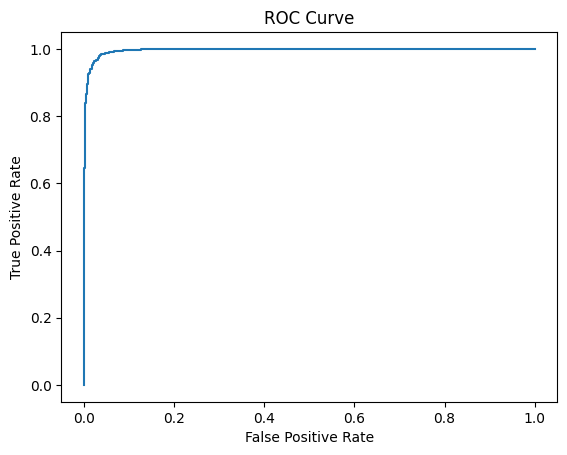

In [41]:
auc_score = roc_auc_score(all_labels, all_probs)
print("AUC Score:", auc_score)

fpr, tpr, _ = roc_curve(all_labels, all_probs)

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()


In [ ]:
import torch
import torch.nn as nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns

# --- Load your saved model ---
model = models.efficientnet_b4(weights=None)
in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(in_features, 2)
)
model.load_state_dict(torch.load("/kaggle/input/models/sbop1232/xrayefficientnetb4model/pytorch/default/1/best_model.pth"))
model = model.to(device)
model.eval()

# --- Evaluate model ---
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

print(classification_report(all_labels, all_preds))
auc = roc_auc_score(all_labels, [p[1] for p in all_probs])
print("AUC Score:", auc)

# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap='Reds')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# --- Grad-CAM Setup ---
target_layer = model.features[-1]  # Last convolutional block of EfficientNet-B4

activations = []
gradients = []

def forward_hook(module, input, output):
    activations.append(output.detach())

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0].detach())

handle_f = target_layer.register_forward_hook(forward_hook)
handle_b = target_layer.register_full_backward_hook(backward_hook)

# --- Grad-CAM function ---
def grad_cam(image_tensor, label):
    model.zero_grad()
    activations.clear()
    gradients.clear()
    
    output = model(image_tensor)
    pred_class = output.argmax(dim=1).item()
    
    output[0, pred_class].backward()
    
    act = activations[0].cpu().numpy()[0]
    grad = gradients[0].cpu().numpy()[0]
    weights = np.mean(grad, axis=(1,2))
    
    cam = np.zeros(act.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * act[i]
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam = cam / cam.max()
    
    img_display = image_tensor[0].permute(1,2,0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img_display = img_display * std + mean
    img_display = np.clip(img_display, 0, 1)
    
    plt.figure(figsize=(6,6))
    plt.imshow(img_display)
    plt.imshow(cam, cmap='jet', alpha=0.45)
    plt.title(f"Grad-CAM • Pred: {pred_class} | True: {label}")
    plt.axis('off')
    plt.show()

# --- Visualize a few Grad-CAMs ---
for i in range(5):
    image, label = test_dataset[i]  # test_dataset = ImageFolder with val/test transforms
    grad_cam(image.unsqueeze(0).to(device), label)
    
# --- Remove hooks ---
handle_f.remove()
handle_b.remove()
